In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import History

/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# To train on vectors made of two decks 
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)

In [2]:
decks = pd.read_csv('decks.csv', index_col=0)
# All probabilities are already in decks.csv
# prob = pd.read_csv('prob.csv', index_col=0)

Some visualisation in lower dimensions

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000)
tsne_results = tsne.fit_transform(decks.iloc[:, 0:-5])

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.007s...
[t-SNE] Computed neighbors for 400 samples in 0.121s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 2.705503


[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.960487


[t-SNE] Error after 1000 iterations: 0.144068


/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


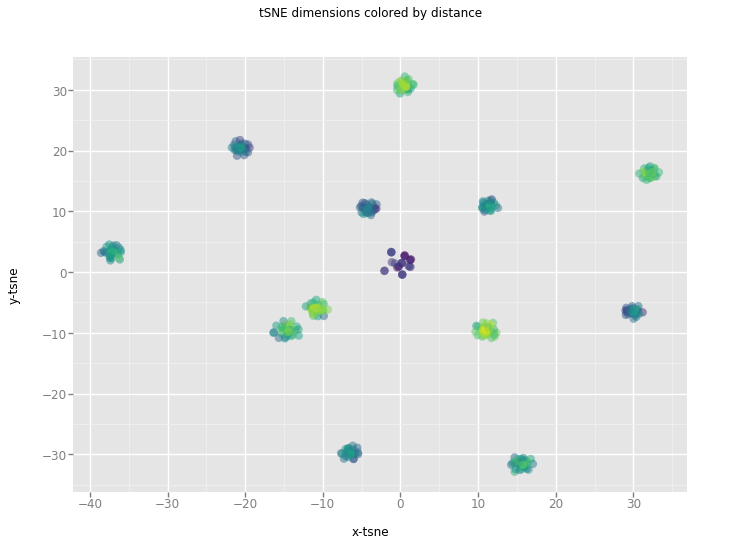

<ggplot: (8742412514217)>

In [6]:
%matplotlib inline
from ggplot import *

df_tsne = decks.copy()
df_tsne['x-tsne'] = tsne_results[:, 0]
df_tsne['y-tsne'] = tsne_results[:, 1]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne')) \
        + geom_point(aes(colour='prob'), size=70, alpha=0.5) \
        + ggtitle("tSNE dimensions colored by distance")
chart

Preparing data:

In [3]:
def add_bot_dummies(old_data_set):
    """Returns new data set with 4 times more rows and dummies for four bots."""
    # Data set should not contain probabilities
    data_set = np.array(old_data_set, dtype=np.int)
    
    nrows = data_set.shape[0]
    
    data_set = np.append(data_set, data_set, axis=0)
    data_set = np.append(data_set, data_set, axis=0)
    
    bots = np.zeros((1600, 4), dtype=np.int)
    bots[0:nrows, 0] = 1
    bots[nrows:2*nrows, 1] = 1
    bots[2*nrows:3*nrows, 2] = 1
    bots[3*nrows:4*nrows, 3] = 1
    
    data_set = np.append(data_set, bots, axis=1)
    
    return data_set

In [4]:
X_train = add_bot_dummies(decks.iloc[:, 0:-5].copy())

In [5]:
def get_bots_prob(bots_prob):
    """"Given array of probabilities for four bots returns 2D array with 4 times more rows and 4 times less columns"""
    bot_1 = np.array(bots_prob.iloc[:, 0], dtype=np.float)
    bot_2 = np.array(bots_prob.iloc[:, 1], dtype=np.float)
    bot_3 = np.array(bots_prob.iloc[:, 2], dtype=np.float)
    bot_4 = np.array(bots_prob.iloc[:, 3], dtype=np.float)
    
    bots = np.append(bot_1, bot_2, axis=0)
    bots = np.append(bots, bot_3, axis=0)
    bots = np.append(bots, bot_4, axis=0)
    bots = np.expand_dims(bots, axis=1)
    
    return bots

In [6]:
y_train = get_bots_prob(decks.iloc[:, -4:].copy())

In [7]:
def shuffle_and_expand_dims(X_train, y_train):
    
    if X_train.shape[0] != y_train.shape[0]:
        print("Wrong input")
        print("Number of rows in X: " + str(X_train.shape[0]))
        print("Number of rows in y: " + str(y_train.shape[0]))
    
    temp = np.append(X_train, y_train, axis=1)
    np.random.shuffle(temp)
    X_train = temp[:, 0:-1]
    y_train = temp[:, -1]
    
    # Keras sequential needs input to have 3D and clases (and predictions) to have 2D
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=1)
    
    return X_train, y_train

In [8]:
X_train, y_train = shuffle_and_expand_dims(X_train, y_train)

In [10]:
print(X_train.shape)
print(y_train.shape)

(1600, 343, 1)
(1600, 1)


Preparation of data to treat problem as classification with single class

In [76]:
def f(x):
    if x >= 0.5:
        return 1
    return 0

In [81]:
y_train_classification = pd.DataFrame(y_train)
y_train_classification = y_train_classification.applymap(f)
#y_train_classification = np.expand_dims(np.array(y_train_classification), axis=1)

In [82]:
print(y_train_classification.shape)

(1600, 1)


Preparation of data to treat problem as classification with two classes to use softmax

In [96]:
def g(x):
    if x == 0:
        return 1
    return 0

In [100]:
y_train_classification2 = pd.DataFrame(y_train_classification).applymap(g)
y_train_classification2 = np.append(y_train_classification, np.array(y_train_classification2), axis=1)

In [101]:
print(y_train_classification2)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


Creating model:

In [17]:
batch_size = 100
num_classes = 1
nepochs = 200
learning_rate = 0.03
decay_rate = learning_rate / nepochs

In [18]:
model = Sequential()

activation_function = 'relu'

model.add(Conv1D(32, 3, padding='same', input_shape=(343, 1), activation=activation_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.1))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.2))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.3))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500, activation=activation_function))
#model.add(Dropout(0.4))
model.add(Dense(500, activation=activation_function))
model.add(Dense(num_classes, activation='sigmoid'))

In [19]:
#opt = keras.optimizers.RMSprop(lr=0.2)
opt = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, decay=decay_rate, nesterov=True)
#opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

Training:

In [20]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=nepochs)

Epoch 1/200


 100/1600 [>.............................] - ETA: 4s - loss: 0.0120 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 1s - loss: 0.0141 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0155 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0150 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0149 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0153 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0153 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0152 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 478us/step - loss: 0.0151 - acc: 0.0000e+00


Epoch 2/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0141 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0149 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0139 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0141 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0142 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0144 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0147 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0148 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 323us/step - loss: 0.0149 - acc: 0.0000e+00


Epoch 3/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0125 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0150 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0157 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0148 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0150 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0149 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0148 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0147 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 314us/step - loss: 0.0147 - acc: 0.0000e+00


Epoch 4/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0143 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0133 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0138 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0139 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0139 - acc: 0.0000e+00



1000/1600 [=================>............] - ETA: 0s - loss: 0.0140 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0141 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0145 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 350us/step - loss: 0.0146 - acc: 0.0000e+00


Epoch 5/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0122 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0143 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0145 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0146 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0141 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0146 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0146 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0143 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 319us/step - loss: 0.0143 - acc: 0.0000e+00


Epoch 6/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0133 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0148 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0149 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0143 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0143 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0145 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0144 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0142 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 313us/step - loss: 0.0141 - acc: 0.0000e+00


Epoch 7/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0179 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0149 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0147 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0144 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0139 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0138 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0136 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0138 - acc: 0.0000e+00

1600/1600 [==============================] - 0s 309us/step - loss: 0.0139 - acc: 0.0000e+00


Epoch 8/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0167 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0133 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0128 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0133 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0138 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0138 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0137 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0137 - acc: 0.0000e+00

1600/1600 [==============================] - 0s 309us/step - loss: 0.0136 - acc: 0.0000e+00


Epoch 9/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0157 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0147 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0133 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0134 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0133 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0133 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0134 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0133 - acc: 0.0000e+00

1600/1600 [==============================] - 0s 309us/step - loss: 0.0133 - acc: 0.0000e+00


Epoch 10/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0163 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0137 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0139 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0136 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0135 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0129 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0132 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0130 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 338us/step - loss: 0.0129 - acc: 0.0000e+00


Epoch 11/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0144 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0140 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0131 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0125 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0126 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0125 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0124 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0123 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 313us/step - loss: 0.0124 - acc: 0.0000e+00


Epoch 12/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0101 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0118 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0115 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0116 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0115 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0116 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0118 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0119 - acc: 0.0000e+00

1600/1600 [==============================] - 0s 309us/step - loss: 0.0119 - acc: 0.0000e+00


Epoch 13/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0132 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0130 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0127 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0124 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0120 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0116 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0114 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0112 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 314us/step - loss: 0.0113 - acc: 0.0000e+00


Epoch 14/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0079 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0106 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0104 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0103 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0102 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0103 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0105 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0105 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 317us/step - loss: 0.0106 - acc: 0.0000e+00


Epoch 15/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0114 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0101 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0099 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0100 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0100 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0097 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0097 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0098 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 317us/step - loss: 0.0098 - acc: 0.0000e+00


Epoch 16/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0122 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0115 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0104 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0098 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0094 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0093 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0092 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0090 - acc: 0.0000e+00

1600/1600 [==============================] - 0s 312us/step - loss: 0.0090 - acc: 0.0000e+00


Epoch 17/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0099 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0082 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0083 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0080 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0081 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0083 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0082 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0082 - acc: 0.0000e+00

1600/1600 [==============================] - 0s 307us/step - loss: 0.0082 - acc: 0.0000e+00


Epoch 18/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0089 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0081 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0084 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0081 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0079 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0077 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0076 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0077 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 319us/step - loss: 0.0076 - acc: 0.0000e+00


Epoch 19/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0080 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0074 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0069 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0069 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0070 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0072 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0072 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0070 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 313us/step - loss: 0.0070 - acc: 0.0000e+00


Epoch 20/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0085 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0078 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0071 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0069 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0067 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0069 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0068 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0067 - acc: 0.0000e+00

1600/1600 [==============================] - 0s 309us/step - loss: 0.0066 - acc: 0.0000e+00


Epoch 21/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0060 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0065 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0065 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0065 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0064 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0062 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0063 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0063 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 315us/step - loss: 0.0062 - acc: 0.0000e+00


Epoch 22/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0075 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0070 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0066 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0061 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0060 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0059 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0058 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0059 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 346us/step - loss: 0.0059 - acc: 0.0000e+00


Epoch 23/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0051 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0054 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0055 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0056 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0057 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0057 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0057 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0057 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0057 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 354us/step - loss: 0.0056 - acc: 0.0000e+00


Epoch 24/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0068 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0068 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0063 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0062 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0060 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0058 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0057 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0056 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0055 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0056 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0056 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0055 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 550us/step - loss: 0.0054 - acc: 0.0000e+00


Epoch 25/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0048 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0051 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0053 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0053 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0055 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0053 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0053 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0052 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 386us/step - loss: 0.0052 - acc: 0.0000e+00


Epoch 26/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0057 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0051 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0048 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0048 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0049 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0050 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0051 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0051 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 362us/step - loss: 0.0050 - acc: 0.0000e+00


Epoch 27/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0044 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0048 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0045 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0048 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0047 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0048 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0048 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0048 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 352us/step - loss: 0.0049 - acc: 0.0000e+00


Epoch 28/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0054 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0051 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0048 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0047 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0047 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0047 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 360us/step - loss: 0.0047 - acc: 0.0000e+00


Epoch 29/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0042 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0047 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0044 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0044 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0045 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0047 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 499us/step - loss: 0.0046 - acc: 0.0000e+00


Epoch 30/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0060 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0052 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 1s - loss: 0.0050 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0049 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0048 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0047 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0045 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 557us/step - loss: 0.0045 - acc: 0.0000e+00


Epoch 31/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0057 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0045 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0046 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0044 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0044 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 380us/step - loss: 0.0043 - acc: 0.0000e+00


Epoch 32/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0042 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0044 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0044 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0045 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0044 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 318us/step - loss: 0.0042 - acc: 0.0000e+00


Epoch 33/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0042 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0042 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0041 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0041 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0041 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0041 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0042 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 320us/step - loss: 0.0042 - acc: 0.0000e+00


Epoch 34/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0042 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0041 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 524us/step - loss: 0.0040 - acc: 0.0000e+00


Epoch 35/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0044 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0042 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0042 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0041 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0043 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0042 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0041 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0041 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 525us/step - loss: 0.0040 - acc: 0.0000e+00


Epoch 36/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0037 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 366us/step - loss: 0.0039 - acc: 0.0000e+00


Epoch 37/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0040 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0039 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 512us/step - loss: 0.0039 - acc: 0.0000e+00


Epoch 38/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0032 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0033 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0037 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0037 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0037 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0037 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0037 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0037 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 782us/step - loss: 0.0037 - acc: 0.0000e+00


Epoch 39/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0033 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0038 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 1s - loss: 0.0035 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0037 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 669us/step - loss: 0.0037 - acc: 0.0000e+00


Epoch 40/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0044 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0037 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0037 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 608us/step - loss: 0.0036 - acc: 0.0000e+00


Epoch 41/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0042 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0032 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 1s - loss: 0.0031 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 648us/step - loss: 0.0035 - acc: 0.0000e+00


Epoch 42/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 522us/step - loss: 0.0035 - acc: 0.0000e+00


Epoch 43/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0032 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 502us/step - loss: 0.0034 - acc: 0.0000e+00


Epoch 44/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 419us/step - loss: 0.0033 - acc: 0.0000e+00


Epoch 45/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0036 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0035 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 416us/step - loss: 0.0033 - acc: 0.0000e+00


Epoch 46/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0034 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0033 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 617us/step - loss: 0.0032 - acc: 0.0000e+00


Epoch 47/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0027 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0028 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 623us/step - loss: 0.0032 - acc: 0.0000e+00


Epoch 48/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 471us/step - loss: 0.0031 - acc: 0.0000e+00


Epoch 49/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0038 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 407us/step - loss: 0.0031 - acc: 0.0000e+00


Epoch 50/200
 100/1600 [>.............................] - ETA: 1s - loss: 0.0028 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 595us/step - loss: 0.0030 - acc: 0.0000e+00


Epoch 51/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0035 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0030 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 649us/step - loss: 0.0030 - acc: 0.0000e+00


Epoch 52/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 528us/step - loss: 0.0030 - acc: 0.0000e+00


Epoch 53/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0032 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 651us/step - loss: 0.0029 - acc: 0.0000e+00


Epoch 54/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0023 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0025 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 631us/step - loss: 0.0029 - acc: 0.0000e+00


Epoch 55/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 517us/step - loss: 0.0028 - acc: 0.0000e+00


Epoch 56/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0029 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 503us/step - loss: 0.0028 - acc: 0.0000e+00


Epoch 57/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0030 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 471us/step - loss: 0.0027 - acc: 0.0000e+00


Epoch 58/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 444us/step - loss: 0.0027 - acc: 0.0000e+00


Epoch 59/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 422us/step - loss: 0.0027 - acc: 0.0000e+00


Epoch 60/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 415us/step - loss: 0.0027 - acc: 0.0000e+00


Epoch 61/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 419us/step - loss: 0.0026 - acc: 0.0000e+00


Epoch 62/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 415us/step - loss: 0.0026 - acc: 0.0000e+00


Epoch 63/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 390us/step - loss: 0.0025 - acc: 0.0000e+00


Epoch 64/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 400us/step - loss: 0.0025 - acc: 0.0000e+00


Epoch 65/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 393us/step - loss: 0.0025 - acc: 0.0000e+00


Epoch 66/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 401us/step - loss: 0.0024 - acc: 0.0000e+00


Epoch 67/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0031 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0028 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 418us/step - loss: 0.0024 - acc: 0.0000e+00


Epoch 68/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0026 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 511us/step - loss: 0.0024 - acc: 0.0000e+00


Epoch 69/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 441us/step - loss: 0.0024 - acc: 0.0000e+00


Epoch 70/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 423us/step - loss: 0.0024 - acc: 0.0000e+00


Epoch 71/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 408us/step - loss: 0.0023 - acc: 0.0000e+00


Epoch 72/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 442us/step - loss: 0.0023 - acc: 0.0000e+00


Epoch 73/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 399us/step - loss: 0.0023 - acc: 0.0000e+00


Epoch 74/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0027 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 409us/step - loss: 0.0022 - acc: 0.0000e+00


Epoch 75/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 426us/step - loss: 0.0022 - acc: 0.0000e+00


Epoch 76/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 401us/step - loss: 0.0022 - acc: 0.0000e+00


Epoch 77/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 410us/step - loss: 0.0022 - acc: 0.0000e+00


Epoch 78/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 424us/step - loss: 0.0021 - acc: 0.0000e+00


Epoch 79/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 403us/step - loss: 0.0021 - acc: 0.0000e+00


Epoch 80/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 401us/step - loss: 0.0021 - acc: 0.0000e+00


Epoch 81/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0025 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 411us/step - loss: 0.0021 - acc: 0.0000e+00


Epoch 82/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0023 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 435us/step - loss: 0.0021 - acc: 0.0000e+00


Epoch 83/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 432us/step - loss: 0.0020 - acc: 0.0000e+00


Epoch 84/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 408us/step - loss: 0.0020 - acc: 0.0000e+00


Epoch 85/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 404us/step - loss: 0.0020 - acc: 0.0000e+00


Epoch 86/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 419us/step - loss: 0.0020 - acc: 0.0000e+00


Epoch 87/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 397us/step - loss: 0.0020 - acc: 0.0000e+00


Epoch 88/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 407us/step - loss: 0.0020 - acc: 0.0000e+00


Epoch 89/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 406us/step - loss: 0.0019 - acc: 0.0000e+00


Epoch 90/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0023 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 450us/step - loss: 0.0019 - acc: 0.0000e+00


Epoch 91/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 411us/step - loss: 0.0019 - acc: 0.0000e+00


Epoch 92/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0022 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 409us/step - loss: 0.0019 - acc: 0.0000e+00


Epoch 93/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 468us/step - loss: 0.0019 - acc: 0.0000e+00


Epoch 94/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 408us/step - loss: 0.0019 - acc: 0.0000e+00


Epoch 95/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 434us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 96/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 457us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 97/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 402us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 98/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0024 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0021 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 401us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 99/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 415us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 100/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 431us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 101/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 412us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 102/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 393us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 103/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 440us/step - loss: 0.0018 - acc: 0.0000e+00


Epoch 104/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 425us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 105/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 408us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 106/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 399us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 107/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 416us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 108/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 418us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 109/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 422us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 110/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 410us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 111/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 403us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 112/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 423us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 113/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 444us/step - loss: 0.0017 - acc: 0.0000e+00


Epoch 114/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0020 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 424us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 115/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 411us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 116/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 451us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 117/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 411us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 118/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 402us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 119/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0019 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 418us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 120/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 421us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 121/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 408us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 122/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 420us/step - loss: 0.0016 - acc: 0.0000e+00


Epoch 123/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 445us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 124/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 411us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 125/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 410us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 126/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 423us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 127/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 437us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 128/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 414us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 129/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 418us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 130/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 396us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 131/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 432us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 132/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 414us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 133/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 415us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 134/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 459us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 135/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 411us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 136/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 407us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 137/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 423us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 138/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 434us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 139/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 420us/step - loss: 0.0015 - acc: 0.0000e+00


Epoch 140/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 410us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 141/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 430us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 142/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 446us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 143/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 482us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 144/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 419us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 145/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 407us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 146/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 427us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 147/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 420us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 148/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 409us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 149/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 422us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 150/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0017 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 412us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 151/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0012 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 445us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 152/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 419us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 153/200
 100/1600 [>.............................] - ETA: 0s - loss: 9.3895e-04 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00    

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 420us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 154/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 410us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 155/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 442us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 156/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 406us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 157/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 472us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 158/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 439us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 159/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 425us/step - loss: 0.0014 - acc: 0.0000e+00


Epoch 160/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 422us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 161/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 421us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 162/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 448us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 163/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 418us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 164/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 403us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 165/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 469us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 166/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 444us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 167/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 421us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 168/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 447us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 169/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 480us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 170/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 458us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 171/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 442us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 172/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 420us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 173/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 449us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 174/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 415us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 175/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 428us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 176/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 414us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 177/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 486us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 178/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 415us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 179/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 433us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 180/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 453us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 181/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 425us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 182/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 414us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 183/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 431us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 184/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 449us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 185/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 421us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 186/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 420us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 187/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 430us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 188/200
 100/1600 [>.............................] - ETA: 0s - loss: 9.0897e-04 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00    

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 459us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 189/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0016 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 421us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 190/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 424us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 191/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0010 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 452us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 192/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 418us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 193/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0018 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0015 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 417us/step - loss: 0.0013 - acc: 0.0000e+00


Epoch 194/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0010 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 9.2586e-04 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00    

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 422us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 195/200


 100/1600 [>.............................] - ETA: 1s - loss: 0.0012 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 448us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 196/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0014 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 422us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 197/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1000/1600 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 428us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 198/200


 100/1600 [>.............................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0011 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 453us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 199/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 458us/step - loss: 0.0012 - acc: 0.0000e+00


Epoch 200/200
 100/1600 [>.............................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 700/1600 [============>.................] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0012 - acc: 0.0000e+00

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 0.0000e+00

1600/1600 [==============================] - 1s 443us/step - loss: 0.0012 - acc: 0.0000e+00


In [21]:
print(history.history.keys())

dict_keys(['acc', 'loss'])


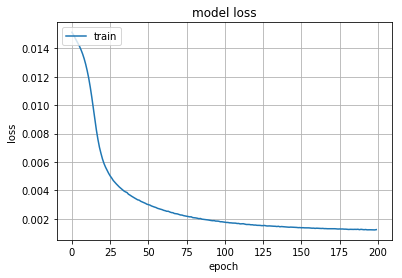

In [22]:
%matplotlib inline 
plt.plot(history.history['loss'])
#plt.plot(history.history['mean_squared_error'], label='Mean Squared Error')
plt.grid()
plt.legend(['train'], loc='upper left')
plt.title('model loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [23]:
def getResults():
    X_test = pd.read_csv("X_test.csv", index_col=0)
    X_test_big = np.array(X_test.copy(), dtype=float)
    X_test_big = np.append(X_test_big, X_test_big, axis=0)
    X_test_big = np.append(X_test_big, X_test_big, axis=0)
    
    bots = np.zeros((800, 4), dtype=np.int)
    bots[0:200, 0] = 1
    bots[200:400, 1] = 1
    bots[400:600, 2] = 1
    bots[600:800, 3] = 1
    
    X_test_big = np.append(X_test_big, bots, axis=1)
    X_test_big = np.expand_dims(X_test_big, axis=2)
    
    print(X_test_big.shape)
    
    y_test_big = model.predict_proba(X_test_big)
    
    print(y_test_big.shape)
    
    bots_list = ['A1'] * 200 + ['A2'] * 200 + ['B1'] * 200 + ['B2'] * 200
    output = pd.DataFrame(bots_list, columns=['bot'])
    output['deck'] = list(X_test.index) * 4
    output['prob'] = y_test_big     # For two classes [:, 0]
    
    def f(x):
        return x * 100
    
    output['prob'] = output['prob'].apply(f)
    #output['prob'] = output['prob'].apply(lambda x: round(x, 2))
    print(output)
    
    output.to_csv('results.csv', sep=';', header=False, index=False)

In [24]:
getResults()

(800, 343, 1)


(800, 1)
    bot        deck       prob
0    A1  deck244804  33.896127
1    A1  deck124802  48.563054
2    A1  deck687350  42.804018
3    A1  deck517728  45.558307
4    A1  deck130762  48.497590
5    A1  deck322071  34.721449
6    A1  deck874296  55.050433
7    A1  deck206745  51.952469
8    A1  deck895482  70.233995
9    A1  deck160842  42.820793
10   A1  deck838916  43.305832
11   A1  deck780914  44.285035
12   A1  deck750047  38.532242
13   A1  deck652829  42.235231
14   A1  deck804465  36.613160
15   A1  deck527231  49.437836
16   A1  deck564938  45.107654
17   A1  deck960955  53.798187
18   A1  deck573326  54.556519
19   A1  deck197957  40.357837
20   A1  deck592549  49.250677
21   A1  deck590796  47.258997
22   A1  deck454901  45.969856
23   A1  deck224429  57.786387
24   A1  deck237007  44.245687
25   A1  deck679633  48.605001
26   A1  deck333404  42.340326
27   A1  deck865510  49.003601
28   A1  deck445345  38.006908
29   A1  deck331249  68.488747
..   ..         ...        ...